# Preparing Data

In [30]:
import pandas as pd
import numpy as np
import ml_utils as ml
import ml_utils_classification as mlc
import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv("datasets/kr_ticker-sentiment_smLag3.csv")

In [32]:
df = df.set_index(['date']).sort_index()
df['delta'] = df['Close'].diff()
df['direction'] = (df['delta'] > 0).astype(int)
df = mlc.direction_momentum(df, horizons=[5,10,20,40,60,80,100,120,140])
df['next_direction'] = df['direction'].shift(-1)
df = df.dropna()

In [33]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Sentiment_mean',
       'Sentiment_sum', 'Sentiment_count', 'Sentiment_count-3',
       'Sentiment_sum-3', 'Sentiment_mean-3', 'delta', 'direction',
       'direction_mom_5', 'direction_mom_10', 'direction_mom_20',
       'direction_mom_40', 'direction_mom_60', 'direction_mom_80',
       'direction_mom_100', 'direction_mom_120', 'direction_mom_140',
       'next_direction'],
      dtype='object')

In [39]:
target = df[['next_direction']]
input = df[['Sentiment_mean',
       'Sentiment_sum', 'Sentiment_count', 'Sentiment_count-3',
       'Sentiment_sum-3', 'Sentiment_mean-3', 'delta', 'direction',
       'direction_mom_5', 'direction_mom_10', 'direction_mom_20',
       'direction_mom_40', 'direction_mom_60', 'direction_mom_80',
       'direction_mom_100', 'direction_mom_120', 'direction_mom_140']]

train_pct = 0.8

X_train, y_train = input.iloc[:int(len(input)*train_pct), :], target.iloc[:int(len(input)*train_pct), :]
X_test, y_test = input.iloc[int(len(input)*train_pct):, :], target.iloc[int(len(input)*train_pct):, :]

# Feature analysis with Lasso

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [41]:
lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LogisticRegression(penalty='l1',
                                solver='saga',
                                C=1,
                                max_iter=1000))
])

lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

In [42]:
from sklearn.metrics import accuracy_score, classification_report

print("Train set evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\nValidation set evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train set evaluation:
Accuracy: 0.5950920245398773
              precision    recall  f1-score   support

         0.0       0.63      0.76      0.69       770
         1.0       0.51      0.36      0.42       534

    accuracy                           0.60      1304
   macro avg       0.57      0.56      0.55      1304
weighted avg       0.58      0.60      0.58      1304


Validation set evaluation:
Accuracy: 0.5797546012269938
              precision    recall  f1-score   support

         0.0       0.63      0.76      0.69       202
         1.0       0.42      0.28      0.34       124

    accuracy                           0.58       326
   macro avg       0.53      0.52      0.52       326
weighted avg       0.55      0.58      0.56       326



Feature selezionate: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


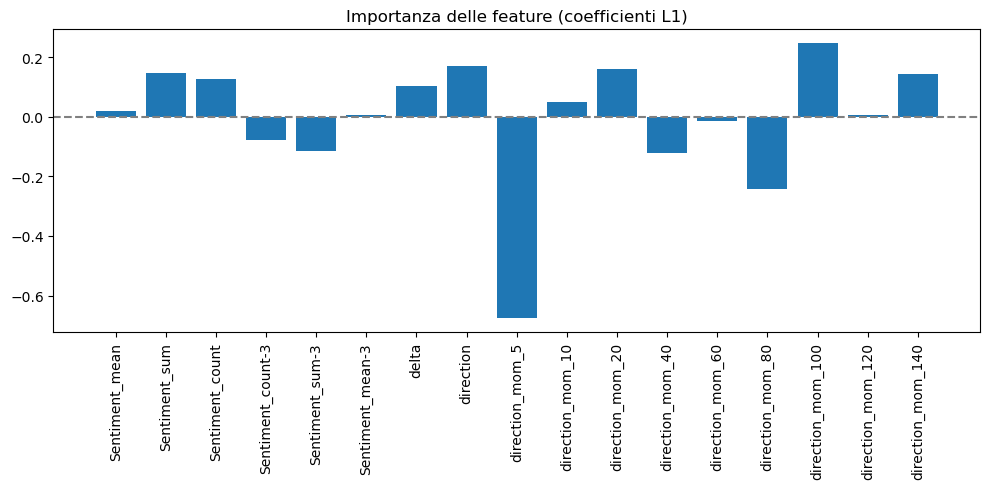

In [43]:
import matplotlib.pyplot as plt
import numpy as np

feature_analyzer = lasso.named_steps['lasso']
coefs = feature_analyzer.coef_[0]
selected = [i for i, w in enumerate(coefs) if w != 0]

print("Feature selezionate:", selected)

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"f{i}" for i in range(X_train.shape[1])]
coefs = feature_analyzer.coef_[0]

plt.figure(figsize=(10, 5))
plt.bar(feature_names, coefs)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.title("Importanza delle feature (coefficienti L1)")
plt.tight_layout()
plt.show()

### Analisi con Seaborn

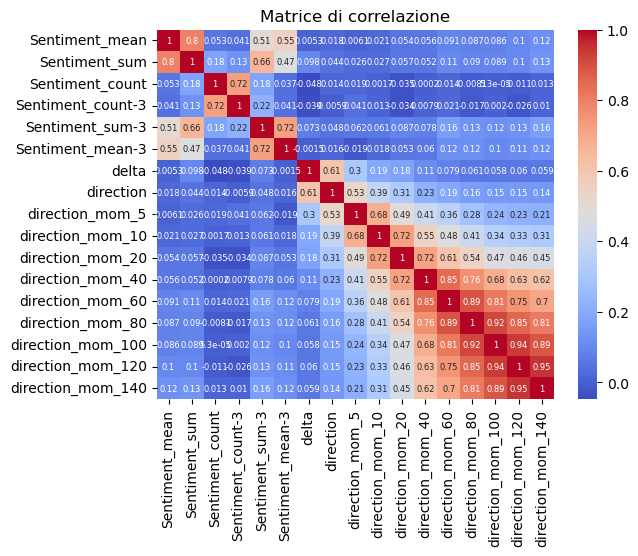

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(input.corr(), annot=True, annot_kws={"size": 6}, cmap='coolwarm')
plt.title("Matrice di correlazione")
plt.show()

# Valori >0.8 o <-0.8 sono da tenere d'occhio

In [47]:
input.columns

Index(['Sentiment_mean', 'Sentiment_sum', 'Sentiment_count',
       'Sentiment_count-3', 'Sentiment_sum-3', 'Sentiment_mean-3', 'delta',
       'direction', 'direction_mom_5', 'direction_mom_10', 'direction_mom_20',
       'direction_mom_40', 'direction_mom_60', 'direction_mom_80',
       'direction_mom_100', 'direction_mom_120', 'direction_mom_140'],
      dtype='object')

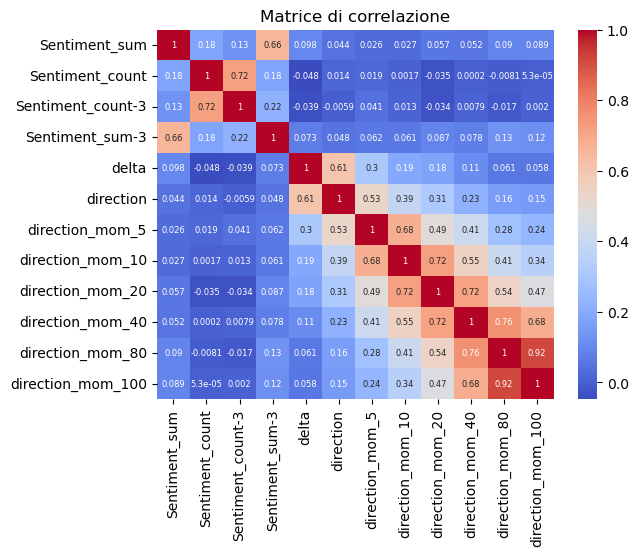

In [51]:
corrected_input = input[['Sentiment_sum', 'Sentiment_count',
       'Sentiment_count-3', 'Sentiment_sum-3', 'delta',
       'direction', 'direction_mom_5', 'direction_mom_10', 'direction_mom_20',
       'direction_mom_40', 'direction_mom_80','direction_mom_100']]
sns.heatmap(corrected_input.corr(), annot=True, annot_kws={"size": 6}, cmap='coolwarm')
plt.title("Matrice di correlazione")
plt.show()

In [52]:
det_corr = np.linalg.det(input.corr())
print("Determinante matrice di correlazione:", det_corr)

det_corr_corr = np.linalg.det(corrected_input.corr())
print("Determinante matrice di correlazione modificata:", det_corr_corr)

Determinante matrice di correlazione: 1.7541152815789636e-07
Determinante matrice di correlazione modificata: 0.0008733933194233934
